# consumidor.gov

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import json
import pathlib

from fastai.text import *

import numpy as np
import pandas as pd
import html

In [ ]:
#path = untar_data(URLs.IMDB_SAMPLE)
path = pathlib.Path("./gov")
#path.ls()

In [ ]:
#df = pd.read_csv(path/'basepython.csv', sep=';;::;;', encoding = 'cp1252', quotechar='\"', engine='python')
df = pd.read_csv(path/'basepython2.csv', sep=';;::;;', quotechar='\"', engine='python')
#df = pd.read_csv(path/'basepython.csv', sep=';')
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""
df.head()

In [ ]:
df['"MANIFESTACAO"'][3]

In [ ]:
PATH = pathlib.Path("./gov/data/")
LANG_FILENAMES = [str(f) for f in PATH.rglob("*/*")]
print(len(LANG_FILENAMES))
LANG_FILENAMES[0:5]

In [ ]:
LM_PATH=Path('lm/')
LM_PATH.mkdir(exist_ok=True)

In [ ]:
#LM TBC...


In [ ]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

In [ ]:
data = df
len(data)

In [ ]:
data['"TEMA"'] = data['"TEMA"'].astype('category')
data.dtypes

In [ ]:
data["temacode"] = data['"TEMA"'].cat.codes
#get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""
data.head(5)

In [ ]:
#raw = data[['"MANIFESTACAO"', '"ASSUNTO"']]
#raw = data[['"MANIFESTACAO"', '"TEMA"']]
raw = data[['temacode', '"MANIFESTACAO"']]

In [ ]:
#raw = raw.rename(columns = {'"MANIFESTACAO"':'text', '"ASSUNTO"': 'label'})
#raw = raw.rename(columns = {'"MANIFESTACAO"':'text', '"TEMA"': 'label'})
raw = raw.rename(columns = {'temacode': 'label', '"MANIFESTACAO"':'text'})
#get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""
raw.head(5)

In [ ]:
trn, val = sklearn.model_selection.train_test_split(
    raw, test_size=0.1)

In [ ]:
trn, tst = sklearn.model_selection.train_test_split(
    trn, test_size=0.15)

In [ ]:
trn.head(5)

In [ ]:
len(trn), len(val), len(tst)

In [ ]:
trn.info()

In [ ]:
#CLASSES = ['neg', 'pos', 'unsup']
CLASSES = data['"TEMA"'].unique().astype('object')
for labeltest in enumerate(CLASSES):
    print(labeltest)

In [ ]:
CLASSES.sort(0);CLASSES

In [ ]:
CLAS_PATH=Path('lm/gov_clas/')
CLAS_PATH.mkdir(exist_ok=True)

In [ ]:
trn = trn[['label', 'text']]

In [ ]:
val = val[['label', 'text']]

In [ ]:
trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w', encoding='utf-8').writelines(f'{o}\n' for o in CLASSES)

In [ ]:
trn.text.head()

In [ ]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn.text,val.text]), test_size=0.1)

In [ ]:
len(trn_texts), len(val_texts)

In [ ]:
#trn_texts[1]

In [ ]:
col_names = ['labels','text']

In [ ]:
LM_PATH=Path('lm/')
LM_PATH.mkdir(exist_ok=True)

In [ ]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False, sep='Ä')
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False, sep='Ä')

In [ ]:
chunksize=24000

In [ ]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [ ]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)
#    texts = texts.apply(fixup).values.astype(str)
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts), lang='pt')
#    tok = Tokenizer().process_all(partition_by_cores(texts, 4))
    return tok, list(labels)

In [ ]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
#u    for i, r in enumerate(n_lbls):
        print(i)
 #       print(r)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels


In [ ]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize, sep='Ä', engine='python')
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize, sep='Ä', engine='python')

In [ ]:
#for chunk in df_val:
#    print(chunk)

In [ ]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [ ]:
tok_val

In [ ]:
df_trn

In [ ]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [ ]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [ ]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [ ]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

In [ ]:
max_vocab = 60000
min_freq = 2

In [ ]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [ ]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

In [ ]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [ ]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [ ]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [ ]:
vs=len(itos)
vs,len(trn_lm)

In [ ]:
em_sz,nh,nl = 400,1150,3

In [ ]:
PATH = pathlib.Path("./gov/data/")

In [ ]:
PRE_PATH = PATH/'models'
PRE_LM_PATH = PRE_PATH/'lm_PT_1_cycle_10_epochs_from_scratch.h5'

In [ ]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [ ]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [ ]:
itos2 = pickle.load((PRE_PATH/'itos.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [ ]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [ ]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

In [ ]:
wd=1e-7
bptt=70
bs=8 #was 52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

# following occupies GPU memory

In [ ]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [ ]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

# following occupies GPU memory

In [ ]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [ ]:
learner.model.load_state_dict(wgts)

In [ ]:
lr=1e-3
lrs = lr

# first learner

In [ ]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

In [ ]:
learner.save('lm_last_ft')

In [ ]:
learner.load('lm_last_ft')

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

In [ ]:
learner.sched.plot()

In [ ]:
lrs = (1e-2)/2

In [ ]:
#learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=5)
#learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=3)

In [ ]:
learner.save('lm1')

In [ ]:
learner.save_encoder('lm1_enc')

In [ ]:
learner.sched.plot_loss()

In [ ]:
learner.load('lm1')

In [ ]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=1)

In [ ]:
learner.sched.plot_loss()

In [ ]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=1)

In [ ]:
learner.sched.plot_loss()

In [ ]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=2)

In [ ]:
learner.sched.plot_loss()

In [ ]:
learner.save('lm1')

In [ ]:
learner.save_encoder('lm1_enc')

# Classifier tokens

In [ ]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [ ]:
#for chunk in df_trn:
 #   print(chunk)

In [ ]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [ ]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [ ]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

# itos needed below

In [3]:
LM_PATH=Path('lm/')
LM_PATH.mkdir(exist_ok=True)

In [4]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

31497

In [ ]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [ ]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

# Classifier - CLAS_PATH needed

In [5]:
CLAS_PATH=Path('lm/gov_clas/')
CLAS_PATH.mkdir(exist_ok=True)

In [6]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [7]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [ ]:
len(trn_clas)

In [ ]:
#vctest = val_clas.copy()

In [ ]:
len(trn_labels)

In [8]:
val_labels = np.append(val_labels, val_labels[0])

In [9]:
trn_labels = np.append(trn_labels, trn_labels[0])

In [10]:
trn_clas.resize((len(trn_clas)+1,))

In [11]:
trn_clas[-1] = trn_clas[0]

In [12]:
val_clas.resize((len(val_clas)+1,))

In [13]:
val_clas[-1] = val_clas[0]

In [ ]:
#vctest[-1] = vctest[0]

In [ ]:
len(trn_labels)

# last hyperparameters

In [14]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
#bs = 48
bs = 8

In [15]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [ ]:
len(val_clas)

In [ ]:
#len(np.concatenate(val_clas, np.array([val_clas[0]])))

In [16]:
PATH = pathlib.Path("./gov/data/")

In [17]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [ ]:
#len(trn_labels)

In [ ]:
#len(np.append(val_labels, val_labels[0]))

In [ ]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [18]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [ ]:
nh

In [19]:
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [20]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

# last learn

In [21]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.25
learn.metrics = [accuracy]

In [22]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

# last lrs

In [23]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

# last wd

In [24]:
wd = 1e-7
#wd = 0
learn.load_encoder('lm1_enc')

# jump to last save

In [25]:
learn.freeze_to(-1)

In [ ]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [26]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))
#learn.precompute = False
#learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(20,10))

epoch      trn_loss   val_loss   accuracy                     
    0      1.251829   1.049514   0.652595  



[array([1.04951]), 0.6525953721075672]

In [27]:
learn.save('clas_0')

In [ ]:
learn.load('clas_0')

In [28]:
learn.freeze_to(-2)

In [29]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                     
    0      1.298147   2.554367   0.652595  



[array([2.55437]), 0.6525953721448434]

In [30]:
learn.save('clas_1')

# tahan asti

In [25]:
learn.load('clas_1')

In [31]:
learn.freeze_to(-3)
#learn.unfreeze()

In [32]:
#learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))
#learn.fit(lrs, 1, wds=wd, cycle_len=4, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                     
    0      1.11258    1.137468   0.681676  



[array([1.13747]), 0.6816760475669823]

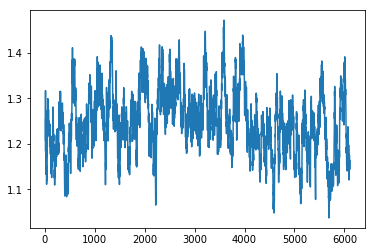

In [33]:
learn.sched.plot_loss()

In [34]:
learn.save('clas_2')

In [35]:
learn.freeze_to(-4)


In [36]:
learn.fit(lrs, 1, wds=wd, cycle_len=2, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                      
    0      1.331979   1.060684   0.679174  
    1      1.173295   0.970814   0.696685                      



[array([0.97081]), 0.6966854284300217]

In [37]:
learn.save('clas_3')

In [38]:
learn.unfreeze()

In [39]:
learn.fit(lrs, 1, wds=wd, cycle_len=2, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                       
    0      1.187277   7.924848   0.667917  
    1      1.070269   0.997028   0.701063                      



[array([0.99703]), 0.7010631645150748]

In [40]:
learn.save('clas_4')

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=2, use_clr=(32,10))

# confusion matrix

In [41]:
interpretation = ClassificationInterpretation.from_learner(learn)

NameError: name 'ClassificationInterpretation' is not defined

In [42]:
learn.plot_confusion_matrix()

AttributeError: 'RNN_Learner' object has no attribute 'plot_confusion_matrix'

In [43]:
learn.predict()

array([[ -3.90484,   0.50706,  -4.63434, ...,   3.01887,  -2.02673,  -3.28693],
       [  1.02299,   1.24168,  -4.4092 , ...,  -0.24988,  -0.65737,  -2.00817],
       [ -0.31985,   0.33216,  -2.49176, ...,  -0.40172,  -1.19837,  -1.08412],
       ...,
       [ -8.79348,  -0.49778, -12.00835, ...,  -3.54327,   2.84287, -11.78173],
       [ -0.22348,   0.57498,  -6.07496, ...,   0.03285,   0.99023,   9.24617],
       [ -5.47696,  -1.97072,  -5.66456, ...,  -4.19503,  -3.58738,  -5.15834]], dtype=float32)

In [44]:
cm = learn.predict()

In [45]:
learn.show_results()

AttributeError: 'RNN_Learner' object has no attribute 'show_results'

In [46]:
cml =learn.predict(is_test=True)

TypeError: 'NoneType' object is not iterable

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at list twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [ ]:
data.vocab.itos[:10]

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [ ]:
data.train_ds[0][0]

But the underlying data is all numbers

In [ ]:
data.train_ds[0][0].data[:10]

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the variaous arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [ ]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [ ]:
bs=16

Now let's grab the full dataset for what follows.

In [ ]:
path = untar_data(URLs.IMDB)
path.ls()

In [ ]:
(path/'train').ls()

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder on top of `train` and `test` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipeia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviex lefts by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [ ]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('tmp_lm')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [ ]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=bs)

In [ ]:
data_lm.show_batch()

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [ ]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
import torch
import gc; gc.collect()
torch.cuda.empty_cache()

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

In [ ]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [ ]:
learn.load('fine_tuned');

In [ ]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [ ]:
path = untar_data(URLs.IMDB)

In [ ]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('tmp_clas')

In [ ]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=bs)

In [ ]:
data_clas.show_batch()

We can then create a model to classify those reviews and load the encoder we saved before.

In [ ]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [ ]:
learn.save('third')

In [ ]:
learn.load('third');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [ ]:
learn.predict("I really loved that movie, it was awesome!")